Esta primera celda carga todas las herramientas y librerías que necesitaremos para el proyecto. Esto incluye PyTorch (para la red neuronal), Torchvision (para las imágenes), NumPy (para cálculos), Matplotlib/Seaborn (para gráficos) y Scikit-learn (para las métricas de evaluación).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
import os
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import datetime

Aquí definimos todas las constantes y variables clave.

In [2]:
CARPETA_DATOS_AGRUPADOS = './dataset_agrupad_o'
DIRECTORIO_DATOS = CARPETA_DATOS_AGRUPADOS
DIRECTORIO_KAGGLE = "/kaggle/input"

print(f"Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de {DIRECTORIO_KAGGLE}...")

DIRECTORIO_ENTRADA_BIOMAS = None
try:
    for ruta_actual, carpetas, archivos in os.walk(DIRECTORIO_KAGGLE, topdown=True):
        if os.path.basename(ruta_actual) == 'preprocessed_data':
            if any(carpeta.startswith('biome_') for carpeta in carpetas):
                DIRECTORIO_ENTRADA_BIOMAS = ruta_actual
                print(f"Directorio de biomas válido encontrado en: {DIRECTORIO_ENTRADA_BIOMAS}")
                print(f"Subdirectorios de biomas detectados (muestra): {carpetas[:5]}")
                break
    if DIRECTORIO_ENTRADA_BIOMAS is None:
        print("--- ERROR FATAL (DETECCIÓN) ---")
        print("No se pudo encontrar un directorio 'preprocessed_data' válido que contenga subcarpetas 'biome_X'.")
        DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"
except Exception as e:
    print(f"Error fatal al buscar directorios: {e}")
    DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"

#Aqui estan definidas estas constantes en funcion de como se presentan las imagenes del dataset 
ALTO_IMAGEN = 180
ANCHO_IMAGEN = 320
TAMANO_LOTE = 32
PROPORCION_VALIDACION = 1 / 3
SEMILLA_ALEATORIA = 123
UMBRAL_MINORIA = 1000

# Este es el mapa de las agrupaciones definidas en el anteproyecto
MAPA_AGRUPACION_BIOMAS = {
    "Taiga": ["biome_5", "biome_19", "biome_32", "biome_33", "biome_133"],
    "Taiga Nevada": ["biome_30", "biome_31", "biome_158"],
    "Savana": ["biome_35", "biome_36"],
    "Jungla": ["biome_21", "biome_22"],
    "Bosque de Roble Oscuro": ["biome_29", "biome_157"],
    "Desierto": ["biome_2", "biome_17", "biome_130"],
    "Badlands": ["biome_37", "biome_38", "biome_39"],
    "Bosque de Abeto": ["biome_27", "biome_28", "biome_156"],
    "Pantano": ["biome_6"],
    "Bosque de Roble": ["biome_4", "biome_132"],
    "Planicies": ["biome_1", "biome_129"],
    "Bosque Mixto": ["biome_18", "biome_34"],
    "Tundra Nevada": ["biome_12"],
    "Montañas": ["biome_3", "biome_131", "biome_162"],
    "Montaña Nevada": ["biome_13"],
    "Playa": ["biome_16", "biome_26"],
    "Ríos": ["biome_7", "biome_11"]
}

BIOMAS_IGNORADOS = ["biome_10", "biome_45"]

Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de /kaggle/input...
Directorio de biomas válido encontrado en: /kaggle/input/minecraft-biomes/preprocessed_data
Subdirectorios de biomas detectados (muestra): ['biome_7', 'biome_12', 'biome_37', 'biome_162', 'biome_158']


Esta celda define la función preparar_y_agrupar_biomas

In [3]:
def preparar_y_agrupar_biomas():
    print(f"Directorio base de entrada detectado: {DIRECTORIO_ENTRADA_BIOMAS}")
    if not DIRECTORIO_ENTRADA_BIOMAS or not os.path.exists(DIRECTORIO_ENTRADA_BIOMAS) or not os.listdir(DIRECTORIO_ENTRADA_BIOMAS):
        print(f"--- ERROR FATAL ---\nEl directorio '{DIRECTORIO_ENTRADA_BIOMAS}' no existe o está vacío.")
        return False

    os.makedirs(CARPETA_DATOS_AGRUPADOS, exist_ok=True)
    print(f"El dataset agrupado se guardará en: {CARPETA_DATOS_AGRUPADOS}")

    try:
        nombres_biomas_originales = next(os.walk(DIRECTORIO_ENTRADA_BIOMAS))[1]
    except (StopIteration, FileNotFoundError) as e:
        print(f"Error: No se encontró una estructura de directorios válida en {DIRECTORIO_ENTRADA_BIOMAS}. {e}")
        return False

    mapa_inverso_biomas = {}
    for nueva_categoria, lista_biomas_antiguos in MAPA_AGRUPACION_BIOMAS.items():
        for bioma_antiguo_id in lista_biomas_antiguos:
            mapa_inverso_biomas[bioma_antiguo_id] = nueva_categoria

    print("Creando directorios de salida para las categorías agrupadas...")
    todas_las_categorias = list(MAPA_AGRUPACION_BIOMAS.keys())
    for nueva_categoria in todas_las_categorias:
        os.makedirs(os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria), exist_ok=True)

    biomas_originales_mapeados = set()
    nombre_carpeta_raiz = os.path.basename(DIRECTORIO_ENTRADA_BIOMAS)

    print(f"Recorriendo {DIRECTORIO_ENTRADA_BIOMAS} en busca de imágenes...")
    for ruta_actual, _, archivos in tqdm(os.walk(DIRECTORIO_ENTRADA_BIOMAS), desc="Procesando biomas"):
        bioma_actual_id = os.path.basename(ruta_actual)

        if bioma_actual_id == nombre_carpeta_raiz or bioma_actual_id in BIOMAS_IGNORADOS:
            continue

        if bioma_actual_id in mapa_inverso_biomas:
            biomas_originales_mapeados.add(bioma_actual_id)
            nueva_categoria = mapa_inverso_biomas[bioma_actual_id]
            directorio_nueva_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria)

            for nombre_imagen in archivos:
                if not nombre_imagen.lower().endswith(('.jpg')):
                    continue

                ruta_origen = os.path.join(ruta_actual, nombre_imagen)
                nombre_destino = f"{bioma_actual_id}_{nombre_imagen}"
                ruta_destino = os.path.join(directorio_nueva_categoria, nombre_destino)

                if os.path.exists(ruta_destino):
                    continue

                try:
                    os.symlink(ruta_origen, ruta_destino)
                except (OSError, NotImplementedError, AttributeError):
                    import shutil
                    shutil.copy2(ruta_origen, ruta_destino)

    print("\n--- Proceso de agrupación completado ---")
    print("\n--- Verificación de Conteo (Desde carpetas de destino) ---")
    conteo_final_categorias = {}
    total_imagenes_agrupadas = 0

    for categoria in todas_las_categorias:
        ruta_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, categoria)
        try:
            archivos_en_categoria = os.listdir(ruta_categoria)
            conteo = len([f for f in archivos_en_categoria if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        except FileNotFoundError:
            conteo = 0
        conteo_final_categorias[categoria] = conteo
    
    total_imagenes_agrupadas = sum(conteo_final_categorias.values())
    print(f"Total de imágenes encontradas en las carpetas de destino: {total_imagenes_agrupadas}")

    if total_imagenes_agrupadas == 0:
        print("0 imagenes procesadas. ¡Algo salió mal!")
    else:
        print("\nCantidad total de imagenes encontradas:")
        for categoria, conteo in conteo_final_categorias.items():
            print(f"- {categoria}: {conteo} imágenes")

    todos_biomas_originales_en_mapa = biomas_originales_mapeados | set(BIOMAS_IGNORADOS)
    biomas_sin_mapa = [b for b in nombres_biomas_originales if b not in todos_biomas_originales_en_mapa]

    if biomas_sin_mapa:
        print(f"\n¡Atención! Los siguientes directorios no fueron mapeados ni excluidos:")
        for b in biomas_sin_mapa: print(f"  - {b}")
    else:
        print("\n¡Perfecto! Todos los directorios fueron trabajados correctamente.")
    
    return True

Esta celda define cargar_y_preparar_datos

In [4]:
def cargar_y_preparar_datos(directorio_datos):
    if not os.path.exists(directorio_datos) or not os.listdir(directorio_datos):
        print(f"Error: El directorio '{directorio_datos}' está vacío o no existe.")
        return None, None, None, None, 0

    transformaciones_entrenamiento = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomResizedCrop((ALTO_IMAGEN, ANCHO_IMAGEN), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformaciones_validacion = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("  -> Escaneando directorio de datos (ImageFolder)...")
    try:
        dataset_completo = datasets.ImageFolder(directorio_datos)
    except Exception as e:
        print(f"Error al cargar datos con ImageFolder desde '{directorio_datos}': {e}")
        return None, None, None, None, 0

    print(f"  -> Escaneo completo. {len(dataset_completo)} imágenes encontradas.")
    nombres_clases = dataset_completo.classes
    numero_de_clases = len(nombres_clases)
    print(f"Clases detectadas ({numero_de_clases}): {nombres_clases}")

    indices = list(range(len(dataset_completo)))
    corte = int(np.floor(PROPORCION_VALIDACION * len(dataset_completo)))

    np.random.seed(SEMILLA_ALEATORIA)
    np.random.shuffle(indices)

    indices_entrenamiento, indices_validacion = indices[corte:], indices[:corte]

    class DatasetPersonalizado(Dataset):
        def __init__(self, subset, transformacion):
            self.subset = subset
            self.transformacion = transformacion
        def __getitem__(self, index):
            imagen, etiqueta = self.subset[index]
            imagen = self.transformacion(imagen)
            return imagen, etiqueta
        def __len__(self):
            return len(self.subset)

    datos_entrenamiento = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_entrenamiento),
        transformacion=transformaciones_entrenamiento
    )
    datos_validacion = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_validacion),
        transformacion=transformaciones_validacion
    )

    print("  -> Calculando pesos para el muestreador (sampler)...")
    etiquetas_entrenamiento = []
    for i in tqdm(indices_entrenamiento, desc="   - Recopilando etiquetas (targets)"):
        etiquetas_entrenamiento.append(dataset_completo.targets[i])

    conteo_por_clase = np.bincount(etiquetas_entrenamiento, minlength=numero_de_clases)

    for i, nombre_clase in enumerate(nombres_clases):
        conteo = conteo_por_clase[i]
        if conteo < UMBRAL_MINORIA and conteo > 0:
            print(f"  -> (Sobremuestreo): {nombre_clase} (índice {i}) con {conteo} imágenes.")
        else:
            print(f"  -> (Normal): {nombre_clase} (índice {i}) con {conteo} imágenes.")

    conteo_por_clase[conteo_por_clase == 0] = 1
    pesos_por_clase = 1. / conteo_por_clase

    lista_pesos_muestras = []
    for t in tqdm(etiquetas_entrenamiento, desc="   - Calculando pesos (weights)"):
        lista_pesos_muestras.append(pesos_por_clase[t])
    pesos_muestras_tensor = torch.from_numpy(np.array(lista_pesos_muestras)).double()

    print("  -> Creando DataLoader de Validación...")
    cargador_validacion = DataLoader(datos_validacion,
                                   batch_size=TAMANO_LOTE,
                                   shuffle=False,
                                   num_workers=2,
                                   pin_memory=True)

    print(f"\nDatasets listos. Entreno: {len(datos_entrenamiento)}, Prueba: {len(datos_validacion)}")
    return datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases

Esta celda define la arquitectura de nuestra Red Neuronal Convolucional (CNN) usando una clase de PyTorch.

In [5]:
class ClasificadorBiomasCNN(nn.Module):
    def __init__(self, numero_de_clases, tipo_arquitectura="estandar"):
        super(ClasificadorBiomasCNN, self).__init__()
        self.tipo_arquitectura = tipo_arquitectura

        capas_convolucionales = []
        if tipo_arquitectura == "estandar":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 256 * 11 * 20

        elif tipo_arquitectura == "simple":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 64 * 45 * 80

        else:
            raise ValueError("Tipo de arquitectura no reconocido. Use 'estandar' o 'simple'.")

        self.extractor_caracteristicas = nn.Sequential(*capas_convolucionales)

        capas_clasificacion = []
        if tipo_arquitectura == "estandar":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 512))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(512, 256))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.3))
            capas_clasificacion.append(nn.Linear(256, numero_de_clases))

        elif tipo_arquitectura == "simple":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(128, numero_de_clases))
        self.clasificador_final = nn.Sequential(*capas_clasificacion)

    def forward(self, imagen):
        caracteristicas = self.extractor_caracteristicas(imagen)
        vector_plano = torch.flatten(caracteristicas, 1)
        puntuaciones = self.clasificador_final(vector_plano)
        return puntuaciones

Esta celda contiene las funciones que gestionan el ciclo de vida del modelo.

In [6]:
def entrenar_modelo(red_neuronal, cargador_entrenamiento, numero_epocas, tasa_aprendizaje, dispositivo):
    funcion_de_perdida = nn.CrossEntropyLoss()
    optimizador = optim.Adam(red_neuronal.parameters(), lr=tasa_aprendizaje)
    historial_perdida = []
    red_neuronal.to(dispositivo)

    for epoca in range(numero_epocas):
        perdida_acumulada = 0.0   
        red_neuronal.train()
        barra_progreso = tqdm(cargador_entrenamiento, desc=f"Época {epoca+1}/{numero_epocas}", unit="batch")

        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            optimizador.zero_grad()
            salidas = red_neuronal(imagenes)
            perdida = funcion_de_perdida(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            perdida_acumulada += perdida.item()
            barra_progreso.set_postfix(loss=perdida.item())
        perdida_promedio_epoca = perdida_acumulada / len(cargador_entrenamiento)
        historial_perdida.append(perdida_promedio_epoca)
        print(f"Época {epoca+1}/{numero_epocas} completada. Loss Promedio: {perdida_promedio_epoca:.4f}")
    print("Entrenamiento finalizado.")
    return historial_perdida

def graficar_historial_perdida(historial_perdida):
    plt.figure()
    plt.plot(historial_perdida, label='Pérdida (Loss) de Entrenamiento')
    plt.title("Historial de Pérdida (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluar_modelo(red_neuronal, cargador_pruebas, dispositivo, nombres_clases):
    red_neuronal.to(dispositivo)
    red_neuronal.eval()
    todas_predicciones = []
    todas_etiquetas_reales = []
    print("Evaluando modelo contra el conjunto de prueba...")
    barra_progreso = tqdm(cargador_pruebas, desc="Evaluando", unit="batch")
    with torch.no_grad():
        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = red_neuronal(imagenes)
            _, prediccion = torch.max(salidas.data, 1)         
            todas_predicciones.extend(prediccion.cpu().numpy())
            todas_etiquetas_reales.extend(etiquetas.cpu().numpy())
    accuracy = accuracy_score(todas_etiquetas_reales, todas_predicciones)
    precision = precision_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)
    recall = recall_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("          RESULTADOS DE LA EVALUACIÓN (BIOMAS)")
    print("="*60)
    print(f"Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision (Precisión - Macro): {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilidad - Macro): {recall:.4f} ({recall*100:.2f}%)")
    print("="*60)
    print("\n--- Reporte de Clasificación (Precisión, Recall, F1) ---")
    print(classification_report(todas_etiquetas_reales, todas_predicciones, target_names=nombres_clases, zero_division=0))
    print("Generando Matriz de Confusión...")
    matriz_confusion = confusion_matrix(todas_etiquetas_reales, todas_predicciones)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases, yticklabels=nombres_clases, annot_kws={"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel("Bioma Predicho", fontsize=12)
    ax.set_ylabel("Bioma Real", fontsize=12)
    ax.set_title("Matriz de Confusión - Biomas", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()
    print("Gráfico de Matriz de Confusión generado.")

Esta celda define funciones de ayuda para gestionar el modelo y probarlo.

In [7]:
def guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo):
    estado_modelo = {
        'state_dict': red_neuronal.to('cpu').state_dict(),
        'arch_params': parametros_arquitectura
    }
    ruta_guardado = os.path.basename(nombre_archivo)
    if not ruta_guardado:
        ruta_guardado = "mi_modelo.pth"     
    torch.save(estado_modelo, ruta_guardado)
    print(f"Modelo guardado en {os.path.abspath(ruta_guardado)}")

def cargar_red_neuronal(nombre_archivo, dispositivo):
    if not os.path.exists(nombre_archivo):
        print(f"Error: El archivo '{nombre_archivo}' no existe.")
        return None, None       
    try:
        estado_cargado = torch.load(nombre_archivo, map_location=dispositivo)
    except Exception as e:
        print(f"Error al leer el archivo. ¿Es un archivo .pth válido? ({e})")
        return None, None
    if 'arch_params' not in estado_cargado or 'state_dict' not in estado_cargado:
        print("Error: El archivo .pth no contiene 'arch_params' o 'state_dict'.")
        return None, None
    parametros_arquitectura = estado_cargado['arch_params']
    if 'num_classes' not in parametros_arquitectura and 'numero_de_clases' in parametros_arquitectura:
        parametros_arquitectura['num_classes'] = parametros_arquitectura.pop('numero_de_clases')
    if 'architecture_type' not in parametros_arquitectura and 'tipo_arquitectura' in parametros_arquitectura:
        parametros_arquitectura['architecture_type'] = parametros_arquitectura.pop('tipo_arquitectura')
    params_creacion = {
        'numero_de_clases': parametros_arquitectura['num_classes'],
        'tipo_arquitectura': parametros_arquitectura.get('architecture_type', 'estandar') # default
    }
    red_neuronal = ClasificadorBiomasCNN(**params_creacion) 
    red_neuronal.load_state_dict(estado_cargado['state_dict'])
    red_neuronal.to(dispositivo)
    print(f"Modelo cargado desde {nombre_archivo} al dispositivo {dispositivo}")
    print("\n--- Configuración de la Red Cargada ---")
    print(f"Tipo: {params_creacion['tipo_arquitectura']}")
    print(f"Salida (Clases): {params_creacion['numero_de_clases']}")
    print(red_neuronal)
    print("--------------------------------------")
    return red_neuronal, parametros_arquitectura

def buscar_imagenes_para_predecir(directorio_busqueda, directorio_a_excluir):
    rutas_imagenes_encontradas = []
    print(f"Buscando imágenes de prueba en: {directorio_busqueda}")
    excluir_dataset_dir = ""
    if directorio_a_excluir and os.path.exists(directorio_a_excluir):
        excluir_dataset_dir = os.path.abspath(directorio_a_excluir)
        print(f"Excluyendo directorio de dataset: {excluir_dataset_dir}")      
    excluir_output_dir = os.path.abspath(CARPETA_DATOS_AGRUPADOS)
    print(f"Excluyendo directorio de salida: {excluir_output_dir}")
    for ruta_actual, _, archivos in os.walk(directorio_busqueda, topdown=True):
        ruta_absoluta = os.path.abspath(ruta_actual) 
        if excluir_dataset_dir and ruta_absoluta.startswith(excluir_dataset_dir):
            continue
        if ruta_absoluta.startswith(excluir_output_dir):
            continue
        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                ruta_completa = os.path.join(ruta_actual, nombre_archivo)
                rutas_imagenes_encontradas.append(ruta_completa)
                
    return rutas_imagenes_encontradas

def predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo):
    print("\n--- Predecir Imagen Individual (Desde Lista) ---")
    imagenes_encontradas = buscar_imagenes_para_predecir(DIRECTORIO_KAGGLE, DIRECTORIO_ENTRADA_BIOMAS)
    
    if not imagenes_encontradas:
        print(f"No se encontraron imágenes de prueba (jpg, png) en '{DIRECTORIO_KAGGLE}'")
        print(f"(Asegúrese de que NO estén dentro de '{DIRECTORIO_ENTRADA_BIOMAS}')")
        print("Por favor, añada un dataset que contenga imágenes de prueba (ej. 'test-images').")
        return

    print("Imágenes de prueba encontradas:")
    for i, ruta_img in enumerate(imagenes_encontradas):
        ruta_mostrada = ruta_img.replace(DIRECTORIO_KAGGLE, '.../input')
        print(f"  {i + 1}: {ruta_mostrada}")

    ruta_elegida = None
    while ruta_elegida is None:
        try:
            opcion_str = input(f"Seleccione el número de la imagen (1-{len(imagenes_encontradas)}): ")
            opcion_int = int(opcion_str) - 1
            if 0 <= opcion_int < len(imagenes_encontradas):
                ruta_elegida = imagenes_encontradas[opcion_int]
            else:
                print("Número fuera de rango. Intente de nuevo.")
        except ValueError:
            print("Entrada no válida. Por favor, ingrese un número.")

    print(f"Cargando imagen seleccionada: {ruta_elegida}")
    try:
        transformaciones_prediccion = transforms.Compose([
            transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        imagen = Image.open(ruta_elegida).convert("RGB")
        imagen_tensor = transformaciones_prediccion(imagen)
        imagen_lote = imagen_tensor.unsqueeze(0)
        red_neuronal.to(dispositivo)
        red_neuronal.eval()

        with torch.no_grad():
            salidas = red_neuronal(imagen_lote.to(dispositivo))
            probabilidades = torch.nn.functional.softmax(salidas, dim=1)
            puntuaciones = probabilidades[0]
            confianza, indice_predicho = torch.max(puntuaciones, 0)

        clase_predicha = nombres_clases[indice_predicho.item()]

        print("\n--- Resultado ---")
        print(f"Archivo: {os.path.basename(ruta_elegida)}")
        print(f"La red cree que es: {clase_predicha}")
        print(f"Confianza: {confianza.item() * 100:.2f}%")

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")

Esta celda define la interfaz de usuario que nos permite interactuar con el modelo cuando corre en draft

In [8]:
def menu_interactivo_modelo(red_neuronal, parametros_arquitectura, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo):
    historial_perdida = []
    
    while True:
        print("\n--- Menú de Red - Clasificador de Biomas ---")
        print(f"Modelo en memoria: {parametros_arquitectura.get('architecture_type', 'N/A')}")
        print("1. Entrenar la red")
        print("2. Probar (Evaluar) la red")
        print("3. Predecir imagen individual")
        print("4. Guardar la red")
        print("5. Volver al menú principal")
        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            try:
                epocas = int(input("Ingrese el número de épocas (ej. 10): ") or 10)
                lr = float(input("Ingrese la tasa de aprendizaje (ej. 0.001): ") or 0.001)
                porcentaje_str = input("Porcentaje del dataset de entrenamiento a usar (1-100) [Default: 100]: ") or "100"
                porcentaje = float(porcentaje_str) / 100.0
                
                if not (0.01 <= porcentaje <= 1.0):
                    print("Porcentaje inválido. Usando 100%.")
                    porcentaje = 1.0
                    
                total_muestras_entrenamiento = len(pesos_muestras_tensor)
                
                if porcentaje < 1.0:
                    muestras_a_usar = int(total_muestras_entrenamiento * porcentaje)
                    print(f"Usando {porcentaje*100:.0f}% del dataset. {muestras_a_usar} muestras por época.")
                else:
                    muestras_a_usar = total_muestras_entrenamiento
                    print(f"Usando 100% del dataset. {muestras_a_usar} muestras por época.")

                muestreador_entrenamiento = torch.utils.data.WeightedRandomSampler(
                    weights=pesos_muestras_tensor,
                    num_samples=muestras_a_usar,
                    replacement=True
                )
                
                cargador_entrenamiento_actual = DataLoader(datos_entrenamiento,
                                                          batch_size=TAMANO_LOTE,
                                                          sampler=muestreador_entrenamiento,
                                                          num_workers=2,
                                                          pin_memory=True)

                print(f"Entrenando por {epocas} épocas con LR={lr} en {dispositivo}...")
                nueva_perdida = entrenar_modelo(red_neuronal, cargador_entrenamiento_actual, epocas, lr, dispositivo)
                historial_perdida.extend(nueva_perdida)
                graficar_historial_perdida(historial_perdida)

            except ValueError:
                print("Error: Entrada no válida.")
        
        elif opcion == '2':
            print(f"Probando modelo contra el conjunto de prueba en {dispositivo}...")
            evaluar_modelo(red_neuronal, cargador_validacion, dispositivo, nombres_clases)
        
        elif opcion == '3':
            predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo)
        
        elif opcion == '4':
            nombre_archivo = input("Ingrese el nombre para guardar el modelo (ej: mi_modelo.pth): ")
            if not nombre_archivo.endswith(".pth"):
                nombre_archivo += ".pth"
            if nombre_archivo:
                guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo)
            else:
                print("Guardado cancelado (nombre vacío).")
        
        elif opcion == '5':
            print("Volviendo al menú principal...")
            break
        
        else:
            print("Opción no válida. Intente de nuevo.")

def menu_principal():
    red_neuronal_activa = None
    params_arquitectura_activos = None
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while True:
        print("\n" + "="*50)
        print("  Panel de Control - Clasificador de Biomas (PyTorch)")
        print(f" (Usando dispositivo: {dispositivo})")
        print("="*50)
        print("1. Preparar datos y Crear nueva red (CNN)")
        print("2. Cargar una red desde archivo (.pth)")
        print("3. Salir")
        opcion_principal = input("Seleccione una opción: ")

        if opcion_principal == '1':
            try:
                print("\n--- FASE 1: Agrupando y verificando el dataset ---")
                if not preparar_y_agrupar_biomas():
                    print("Error crítico en la agrupación del dataset. Abortando.")
                    continue

                print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
                
                if datos_entrenamiento is None:
                    print("No se pudieron cargar los datos. Volviendo al menú.")
                    continue
                print("\n--- FASE 3: Creación de Modelo (CNN) ---")
                opcion_arquitectura = input("¿Qué arquitectura desea? (1: Estándar, 2: Simple) [Default: 1]: ") or "1"
                tipo_arquitectura = "simple" if opcion_arquitectura == "2" else "estandar"
                params_arquitectura_activos = {
                    'num_classes': numero_de_clases,
                    'architecture_type': tipo_arquitectura
                }
                
                params_creacion_modelo = {
                    'numero_de_clases': params_arquitectura_activos['num_classes'],
                    'tipo_arquitectura': params_arquitectura_activos['architecture_type']
                }

                red_neuronal_activa = ClasificadorBiomasCNN(**params_creacion_modelo).to(dispositivo)
                print("\n--- Nueva Red CNN Creada ---")
                print(red_neuronal_activa)
                print("------------------------------")  
                menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except ValueError:
                print("Error: Entrada numérica no válida.")
            except Exception as e:
                print(f"Ocurrió un error creando la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '2':
            print("\n--- Cargar Modelo ---")
            print("Buscando archivos .pth en el directorio actual y subdirectorios...")
            archivos_pth_encontrados = []
            for ruta_actual, _, archivos in os.walk('.'):
                for f in archivos:
                    if f.endswith(".pth"):
                        archivos_pth_encontrados.append(os.path.join(ruta_actual, f))
            
            if not archivos_pth_encontrados:
                print("No se encontraron archivos .pth.")
                print("Asegúrate de haber guardado un modelo previamente.")
                continue

            print("Archivos .pth encontrados:")
            for i, ruta_archivo in enumerate(archivos_pth_encontrados):
                print(f"  {i + 1}: {ruta_archivo}")
            nombre_archivo_cargado = None
            while nombre_archivo_cargado is None:
                try:
                    opcion_str = input(f"Seleccione el número del modelo a cargar (1-{len(archivos_pth_encontrados)}): ")
                    opcion_int = int(opcion_str) - 1
                    if 0 <= opcion_int < len(archivos_pth_encontrados):
                        nombre_archivo_cargado = archivos_pth_encontrados[opcion_int]
                    else:
                        print("Número fuera de rango.")
                except ValueError:
                    print("Entrada no válida.")
            
            print(f"Cargando modelo: {nombre_archivo_cargado}")
            try:
                red_neuronal_activa, params_arquitectura_activos = cargar_red_neuronal(nombre_archivo_cargado, dispositivo)
                
                if red_neuronal_activa and params_arquitectura_activos:
                    print("\n--- FASE 1: Verificando datos (necesarios para la red cargada) ---")
                    if not os.path.exists(DIRECTORIO_DATOS) or not os.listdir(DIRECTORIO_DATOS):
                        print("El directorio de datos agrupados no existe. Ejecutando agrupación...")
                        if not preparar_y_agrupar_biomas():
                            print("Error crítico en la agrupación del dataset. Abortando.")
                            continue
                    else:
                        print("Directorio de datos agrupados encontrado.")
                    print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                    datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)           
                    if datos_entrenamiento is None:
                        print("No se pudieron cargar los datos para la red. Volviendo al menú.")
                        continue        
                    if numero_de_clases != params_arquitectura_activos['num_classes']:
                        print(f"¡ADVERTENCIA! El modelo fue entrenado con {params_arquitectura_activos['num_classes']} clases,")
                        print(f"pero los datos en '{DIRECTORIO_DATOS}' tienen {numero_de_clases} clases.")
                        print("Esto causará un error. Asegúrate de que los datos agrupados coincidan con el modelo.")
                        continue
                        
                    menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except FileNotFoundError:
                print(f"Error: El archivo '{nombre_archivo_cargado}' no fue encontrado.")
            except Exception as e:
                print(f"Ocurrió un error al cargar o probar la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '3':
            print("Saliendo del programa.")
            break
        
        else:
            print("Opción no válida. Por favor, intente de nuevo.")

Punto de ejecucion del codigo donde se termina de definir

--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---
Iniciando flujo automático (sin inputs).

 (Usando dispositivo: cuda)

--- FASE 1: Agrupando y verificando el dataset ---
Directorio base de entrada detectado: /kaggle/input/minecraft-biomes/preprocessed_data
El dataset agrupado se guardará en: ./dataset_agrupad_o
Creando directorios de salida para las categorías agrupadas...
Recorriendo /kaggle/input/minecraft-biomes/preprocessed_data en busca de imágenes...


Procesando biomas: 42it [00:30,  1.40it/s]



--- Proceso de agrupación completado ---

--- Verificación de Conteo (Desde carpetas de destino) ---
Total de imágenes encontradas en las carpetas de destino: 22049

Cantidad total de imagenes encontradas:
- Taiga: 2346 imágenes
- Taiga Nevada: 420 imágenes
- Savana: 1164 imágenes
- Jungla: 444 imágenes
- Bosque de Roble Oscuro: 870 imágenes
- Desierto: 2088 imágenes
- Badlands: 210 imágenes
- Bosque de Abeto: 1122 imágenes
- Pantano: 665 imágenes
- Bosque de Roble: 2850 imágenes
- Planicies: 3186 imágenes
- Bosque Mixto: 1320 imágenes
- Tundra Nevada: 1254 imágenes
- Montañas: 2652 imágenes
- Montaña Nevada: 474 imágenes
- Playa: 540 imágenes
- Ríos: 444 imágenes

¡Perfecto! Todos los directorios fueron trabajados correctamente.

--- FASE 2: Cargando y preparando datasets (PyTorch) ---
  -> Escaneando directorio de datos (ImageFolder)...
  -> Escaneo completo. 22049 imágenes encontradas.
Clases detectadas (17): ['Badlands', 'Bosque Mixto', 'Bosque de Abeto', 'Bosque de Roble', 'Bosqu

   - Recopilando etiquetas (targets): 100%|██████████| 14700/14700 [00:00<00:00, 3276974.16it/s]


  -> (Sobremuestreo): Badlands (índice 0) con 146 imágenes.
  -> (Sobremuestreo): Bosque Mixto (índice 1) con 861 imágenes.
  -> (Sobremuestreo): Bosque de Abeto (índice 2) con 767 imágenes.
  -> (Normal): Bosque de Roble (índice 3) con 1920 imágenes.
  -> (Sobremuestreo): Bosque de Roble Oscuro (índice 4) con 568 imágenes.
  -> (Normal): Desierto (índice 5) con 1406 imágenes.
  -> (Sobremuestreo): Jungla (índice 6) con 305 imágenes.
  -> (Sobremuestreo): Montaña Nevada (índice 7) con 301 imágenes.
  -> (Normal): Montañas (índice 8) con 1783 imágenes.
  -> (Sobremuestreo): Pantano (índice 9) con 450 imágenes.
  -> (Normal): Planicies (índice 10) con 2122 imágenes.
  -> (Sobremuestreo): Playa (índice 11) con 356 imágenes.
  -> (Sobremuestreo): Ríos (índice 12) con 306 imágenes.
  -> (Sobremuestreo): Savana (índice 13) con 774 imágenes.
  -> (Normal): Taiga (índice 14) con 1534 imágenes.
  -> (Sobremuestreo): Taiga Nevada (índice 15) con 273 imágenes.
  -> (Sobremuestreo): Tundra Nevada 

   - Calculando pesos (weights): 100%|██████████| 14700/14700 [00:00<00:00, 2911610.73it/s]

  -> Creando DataLoader de Validación...

Datasets listos. Entreno: 14700, Prueba: 7349

--- FASE 3: Creación de Modelo (CNN) ---
Arquitectura seleccionada: estandar



--- Nueva Red CNN Creada ---

--- FASE 4: Iniciando Entrenamiento ---
Épocas: 100, LR: 0.001, Dataset: 100%


Época 1/100: 100%|██████████| 460/460 [01:11<00:00,  6.47batch/s, loss=1.21]


Época 1/100 completada. Loss Promedio: 1.6289


Época 2/100: 100%|██████████| 460/460 [01:09<00:00,  6.59batch/s, loss=0.409]


Época 2/100 completada. Loss Promedio: 1.0407


Época 3/100: 100%|██████████| 460/460 [01:05<00:00,  7.05batch/s, loss=0.354]


Época 3/100 completada. Loss Promedio: 0.8757


Época 4/100: 100%|██████████| 460/460 [01:05<00:00,  7.06batch/s, loss=0.905]


Época 4/100 completada. Loss Promedio: 0.8016


Época 5/100: 100%|██████████| 460/460 [01:04<00:00,  7.15batch/s, loss=0.495]


Época 5/100 completada. Loss Promedio: 0.7402


Época 6/100: 100%|██████████| 460/460 [01:04<00:00,  7.12batch/s, loss=0.167]


Época 6/100 completada. Loss Promedio: 0.7015


Época 7/100: 100%|██████████| 460/460 [01:04<00:00,  7.09batch/s, loss=1.59]


Época 7/100 completada. Loss Promedio: 0.6170


Época 8/100: 100%|██████████| 460/460 [01:05<00:00,  7.06batch/s, loss=0.736]


Época 8/100 completada. Loss Promedio: 0.5806


Época 9/100: 100%|██████████| 460/460 [01:04<00:00,  7.14batch/s, loss=0.42]


Época 9/100 completada. Loss Promedio: 0.5631


Época 10/100: 100%|██████████| 460/460 [01:03<00:00,  7.19batch/s, loss=0.208]


Época 10/100 completada. Loss Promedio: 0.5308


Época 11/100: 100%|██████████| 460/460 [01:05<00:00,  7.04batch/s, loss=0.496]


Época 11/100 completada. Loss Promedio: 0.4852


Época 12/100: 100%|██████████| 460/460 [01:04<00:00,  7.10batch/s, loss=0.238]


Época 12/100 completada. Loss Promedio: 0.4627


Época 13/100: 100%|██████████| 460/460 [01:04<00:00,  7.11batch/s, loss=0.242]


Época 13/100 completada. Loss Promedio: 0.4642


Época 14/100: 100%|██████████| 460/460 [01:03<00:00,  7.22batch/s, loss=0.962]


Época 14/100 completada. Loss Promedio: 0.4321


Época 15/100: 100%|██████████| 460/460 [01:03<00:00,  7.24batch/s, loss=0.609]


Época 15/100 completada. Loss Promedio: 0.4087


Época 16/100: 100%|██████████| 460/460 [01:07<00:00,  6.77batch/s, loss=0.107]


Época 16/100 completada. Loss Promedio: 0.3952


Época 17/100: 100%|██████████| 460/460 [01:01<00:00,  7.48batch/s, loss=0.394]


Época 17/100 completada. Loss Promedio: 0.4317


Época 18/100: 100%|██████████| 460/460 [01:04<00:00,  7.13batch/s, loss=0.126]


Época 18/100 completada. Loss Promedio: 0.3698


Época 19/100: 100%|██████████| 460/460 [01:03<00:00,  7.19batch/s, loss=0.784]


Época 19/100 completada. Loss Promedio: 0.3490


Época 20/100: 100%|██████████| 460/460 [01:04<00:00,  7.13batch/s, loss=0.258]


Época 20/100 completada. Loss Promedio: 0.3814


Época 21/100: 100%|██████████| 460/460 [01:03<00:00,  7.21batch/s, loss=0.165]


Época 21/100 completada. Loss Promedio: 0.3500


Época 22/100: 100%|██████████| 460/460 [01:02<00:00,  7.33batch/s, loss=0.149]


Época 22/100 completada. Loss Promedio: 0.3308


Época 23/100: 100%|██████████| 460/460 [01:08<00:00,  6.74batch/s, loss=0.11]


Época 23/100 completada. Loss Promedio: 0.3250


Época 24/100: 100%|██████████| 460/460 [01:05<00:00,  7.03batch/s, loss=0.141]


Época 24/100 completada. Loss Promedio: 0.3280


Época 25/100: 100%|██████████| 460/460 [01:07<00:00,  6.84batch/s, loss=0.125]


Época 25/100 completada. Loss Promedio: 0.3021


Época 26/100: 100%|██████████| 460/460 [01:05<00:00,  7.05batch/s, loss=0.157]


Época 26/100 completada. Loss Promedio: 0.3019


Época 27/100: 100%|██████████| 460/460 [01:06<00:00,  6.87batch/s, loss=0.103]


Época 27/100 completada. Loss Promedio: 0.3071


Época 28/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=0.138]


Época 28/100 completada. Loss Promedio: 0.3068


Época 29/100: 100%|██████████| 460/460 [01:11<00:00,  6.47batch/s, loss=0.301]


Época 29/100 completada. Loss Promedio: 0.2793


Época 30/100: 100%|██████████| 460/460 [01:06<00:00,  6.89batch/s, loss=0.663]


Época 30/100 completada. Loss Promedio: 0.2751


Época 31/100: 100%|██████████| 460/460 [01:06<00:00,  6.91batch/s, loss=0.0433]


Época 31/100 completada. Loss Promedio: 0.2976


Época 32/100: 100%|██████████| 460/460 [01:06<00:00,  6.92batch/s, loss=0.731]


Época 32/100 completada. Loss Promedio: 0.2717


Época 33/100: 100%|██████████| 460/460 [01:06<00:00,  6.87batch/s, loss=0.261]


Época 33/100 completada. Loss Promedio: 0.2567


Época 34/100: 100%|██████████| 460/460 [01:04<00:00,  7.08batch/s, loss=0.278]


Época 34/100 completada. Loss Promedio: 0.2721


Época 35/100: 100%|██████████| 460/460 [01:05<00:00,  7.01batch/s, loss=0.619]


Época 35/100 completada. Loss Promedio: 0.2557


Época 36/100: 100%|██████████| 460/460 [01:08<00:00,  6.70batch/s, loss=0.0436]


Época 36/100 completada. Loss Promedio: 0.2657


Época 37/100: 100%|██████████| 460/460 [01:02<00:00,  7.34batch/s, loss=0.0649]


Época 37/100 completada. Loss Promedio: 0.2478


Época 38/100: 100%|██████████| 460/460 [01:04<00:00,  7.18batch/s, loss=0.457]


Época 38/100 completada. Loss Promedio: 0.2460


Época 39/100: 100%|██████████| 460/460 [01:05<00:00,  7.06batch/s, loss=0.23]


Época 39/100 completada. Loss Promedio: 0.2437


Época 40/100: 100%|██████████| 460/460 [01:05<00:00,  6.99batch/s, loss=0.0822]


Época 40/100 completada. Loss Promedio: 0.2605


Época 41/100: 100%|██████████| 460/460 [01:04<00:00,  7.16batch/s, loss=0.0837]


Época 41/100 completada. Loss Promedio: 0.2189


Época 42/100: 100%|██████████| 460/460 [01:01<00:00,  7.51batch/s, loss=0.262]


Época 42/100 completada. Loss Promedio: 0.2317


Época 43/100: 100%|██████████| 460/460 [01:03<00:00,  7.20batch/s, loss=0.986]


Época 43/100 completada. Loss Promedio: 0.2312


Época 44/100: 100%|██████████| 460/460 [01:04<00:00,  7.09batch/s, loss=0.0568]


Época 44/100 completada. Loss Promedio: 0.2209


Época 45/100: 100%|██████████| 460/460 [01:05<00:00,  6.98batch/s, loss=0.005]


Época 45/100 completada. Loss Promedio: 0.2258


Época 46/100: 100%|██████████| 460/460 [01:07<00:00,  6.86batch/s, loss=0.0674]


Época 46/100 completada. Loss Promedio: 0.2090


Época 47/100: 100%|██████████| 460/460 [01:06<00:00,  6.92batch/s, loss=0.0238]


Época 47/100 completada. Loss Promedio: 0.2341


Época 48/100: 100%|██████████| 460/460 [01:04<00:00,  7.12batch/s, loss=0.279]


Época 48/100 completada. Loss Promedio: 0.1978


Época 49/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=0.0963]


Época 49/100 completada. Loss Promedio: 0.2372


Época 50/100: 100%|██████████| 460/460 [01:05<00:00,  7.02batch/s, loss=0.25]


Época 50/100 completada. Loss Promedio: 0.2133


Época 51/100: 100%|██████████| 460/460 [01:03<00:00,  7.23batch/s, loss=0.00419]


Época 51/100 completada. Loss Promedio: 0.2239


Época 52/100: 100%|██████████| 460/460 [01:03<00:00,  7.20batch/s, loss=0.228]


Época 52/100 completada. Loss Promedio: 0.1999


Época 53/100: 100%|██████████| 460/460 [01:04<00:00,  7.09batch/s, loss=0.0955]


Época 53/100 completada. Loss Promedio: 0.1813


Época 54/100: 100%|██████████| 460/460 [01:03<00:00,  7.19batch/s, loss=0.0918]


Época 54/100 completada. Loss Promedio: 0.2317


Época 55/100: 100%|██████████| 460/460 [01:03<00:00,  7.22batch/s, loss=0.015]


Época 55/100 completada. Loss Promedio: 0.2025


Época 56/100: 100%|██████████| 460/460 [01:04<00:00,  7.08batch/s, loss=2.39]


Época 56/100 completada. Loss Promedio: 0.2186


Época 57/100: 100%|██████████| 460/460 [01:05<00:00,  7.05batch/s, loss=0.1]


Época 57/100 completada. Loss Promedio: 0.1954


Época 58/100: 100%|██████████| 460/460 [01:03<00:00,  7.29batch/s, loss=0.362]


Época 58/100 completada. Loss Promedio: 0.1862


Época 59/100: 100%|██████████| 460/460 [01:06<00:00,  6.88batch/s, loss=0.0285]


Época 59/100 completada. Loss Promedio: 0.1848


Época 60/100: 100%|██████████| 460/460 [01:06<00:00,  6.89batch/s, loss=0.00046]


Época 60/100 completada. Loss Promedio: 0.1718


Época 61/100: 100%|██████████| 460/460 [01:08<00:00,  6.71batch/s, loss=0.0284]


Época 61/100 completada. Loss Promedio: 0.1900


Época 62/100: 100%|██████████| 460/460 [01:07<00:00,  6.82batch/s, loss=0.109]


Época 62/100 completada. Loss Promedio: 0.1788


Época 63/100: 100%|██████████| 460/460 [01:12<00:00,  6.38batch/s, loss=0.0298]


Época 63/100 completada. Loss Promedio: 0.1975


Época 64/100: 100%|██████████| 460/460 [01:10<00:00,  6.54batch/s, loss=0.0829]


Época 64/100 completada. Loss Promedio: 0.1970


Época 65/100: 100%|██████████| 460/460 [01:13<00:00,  6.30batch/s, loss=0.0723]


Época 65/100 completada. Loss Promedio: 0.1877


Época 66/100: 100%|██████████| 460/460 [01:19<00:00,  5.79batch/s, loss=0.104]


Época 66/100 completada. Loss Promedio: 0.1690


Época 67/100: 100%|██████████| 460/460 [01:07<00:00,  6.82batch/s, loss=0.0176]


Época 67/100 completada. Loss Promedio: 0.1539


Época 68/100: 100%|██████████| 460/460 [01:06<00:00,  6.94batch/s, loss=0.0844]


Época 68/100 completada. Loss Promedio: 0.1639


Época 69/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=0.00505]


Época 69/100 completada. Loss Promedio: 0.1919


Época 70/100: 100%|██████████| 460/460 [01:07<00:00,  6.85batch/s, loss=0.0402]


Época 70/100 completada. Loss Promedio: 0.1836


Época 71/100: 100%|██████████| 460/460 [01:09<00:00,  6.62batch/s, loss=0.0205]


Época 71/100 completada. Loss Promedio: 0.1692


Época 72/100: 100%|██████████| 460/460 [01:06<00:00,  6.96batch/s, loss=0.0154]


Época 72/100 completada. Loss Promedio: 0.1494


Época 73/100: 100%|██████████| 460/460 [01:07<00:00,  6.77batch/s, loss=0.0149]


Época 73/100 completada. Loss Promedio: 0.1499


Época 74/100: 100%|██████████| 460/460 [01:06<00:00,  6.96batch/s, loss=0.0229]


Época 74/100 completada. Loss Promedio: 0.2113


Época 75/100: 100%|██████████| 460/460 [01:05<00:00,  7.04batch/s, loss=0.0833]


Época 75/100 completada. Loss Promedio: 0.1774


Época 76/100: 100%|██████████| 460/460 [01:04<00:00,  7.09batch/s, loss=0.266]


Época 76/100 completada. Loss Promedio: 0.1572


Época 77/100: 100%|██████████| 460/460 [01:05<00:00,  7.00batch/s, loss=0.194]


Época 77/100 completada. Loss Promedio: 0.1698


Época 78/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=1.3]


Época 78/100 completada. Loss Promedio: 0.1637


Época 79/100: 100%|██████████| 460/460 [01:05<00:00,  7.02batch/s, loss=0.0465]


Época 79/100 completada. Loss Promedio: 0.1570


Época 80/100: 100%|██████████| 460/460 [01:05<00:00,  7.06batch/s, loss=0.22]


Época 80/100 completada. Loss Promedio: 0.1659


Época 81/100: 100%|██████████| 460/460 [01:20<00:00,  5.69batch/s, loss=0.0122]


Época 81/100 completada. Loss Promedio: 0.1443


Época 82/100: 100%|██████████| 460/460 [01:22<00:00,  5.58batch/s, loss=0.104]


Época 82/100 completada. Loss Promedio: 0.1808


Época 83/100: 100%|██████████| 460/460 [01:09<00:00,  6.61batch/s, loss=0.000284]


Época 83/100 completada. Loss Promedio: 0.1580


Época 84/100: 100%|██████████| 460/460 [01:01<00:00,  7.50batch/s, loss=0.181]


Época 84/100 completada. Loss Promedio: 0.1480


Época 85/100: 100%|██████████| 460/460 [01:05<00:00,  6.97batch/s, loss=0.185]


Época 85/100 completada. Loss Promedio: 0.1627


Época 86/100: 100%|██████████| 460/460 [01:05<00:00,  7.00batch/s, loss=0.248]


Época 86/100 completada. Loss Promedio: 0.1509


Época 87/100: 100%|██████████| 460/460 [01:04<00:00,  7.09batch/s, loss=0.0485]


Época 87/100 completada. Loss Promedio: 0.1503


Época 88/100: 100%|██████████| 460/460 [01:06<00:00,  6.87batch/s, loss=0.325]


Época 88/100 completada. Loss Promedio: 0.1518


Época 89/100: 100%|██████████| 460/460 [01:12<00:00,  6.37batch/s, loss=0.244]


Época 89/100 completada. Loss Promedio: 0.1420


Época 90/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=0.02]


Época 90/100 completada. Loss Promedio: 0.1644


Época 91/100: 100%|██████████| 460/460 [01:06<00:00,  6.94batch/s, loss=0.0308]


Época 91/100 completada. Loss Promedio: 0.1462


Época 92/100: 100%|██████████| 460/460 [01:06<00:00,  6.87batch/s, loss=0.197]


Época 92/100 completada. Loss Promedio: 0.1652


Época 93/100: 100%|██████████| 460/460 [01:03<00:00,  7.21batch/s, loss=0.0743]


Época 93/100 completada. Loss Promedio: 0.1633


Época 94/100: 100%|██████████| 460/460 [01:09<00:00,  6.58batch/s, loss=0.138]


Época 94/100 completada. Loss Promedio: 0.1808


Época 95/100: 100%|██████████| 460/460 [01:05<00:00,  7.07batch/s, loss=0.154]


Época 95/100 completada. Loss Promedio: 0.1281


Época 96/100: 100%|██████████| 460/460 [01:00<00:00,  7.65batch/s, loss=0.0715]


Época 96/100 completada. Loss Promedio: 0.1702


Época 97/100: 100%|██████████| 460/460 [01:18<00:00,  5.88batch/s, loss=0.0488]


Época 97/100 completada. Loss Promedio: 0.1281


Época 98/100: 100%|██████████| 460/460 [01:15<00:00,  6.07batch/s, loss=0.187]


Época 98/100 completada. Loss Promedio: 0.1461


Época 99/100: 100%|██████████| 460/460 [01:15<00:00,  6.06batch/s, loss=0.0212]


Época 99/100 completada. Loss Promedio: 0.1541


Época 100/100: 100%|██████████| 460/460 [01:05<00:00,  7.05batch/s, loss=0.0546]


Época 100/100 completada. Loss Promedio: 0.1460
Entrenamiento finalizado.
Generando gráfico de pérdida...


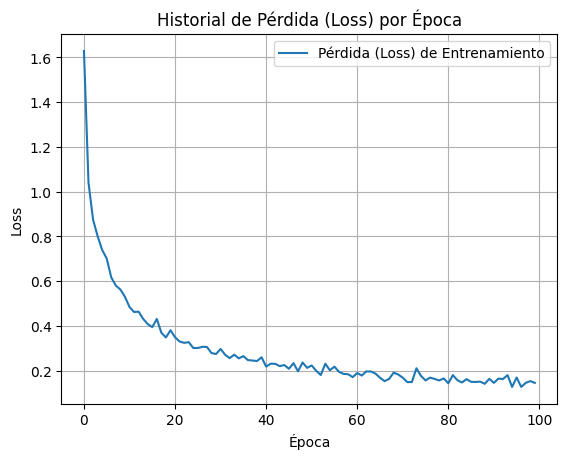


--- FASE 5: Probando modelo en cuda ---
Evaluando modelo contra el conjunto de prueba...


Evaluando: 100%|██████████| 230/230 [00:38<00:00,  5.94batch/s]



          RESULTADOS DE LA EVALUACIÓN (BIOMAS)
Accuracy (Exactitud): 0.8137 (81.37%)
Precision (Precisión - Macro): 0.7752 (77.52%)
Recall (Sensibilidad - Macro): 0.7921 (79.21%)

--- Reporte de Clasificación (Precisión, Recall, F1) ---
                        precision    recall  f1-score   support

              Badlands       0.89      0.98      0.93        64
          Bosque Mixto       0.39      0.28      0.33       459
       Bosque de Abeto       0.85      0.90      0.87       355
       Bosque de Roble       0.75      0.75      0.75       930
Bosque de Roble Oscuro       0.78      0.78      0.78       302
              Desierto       0.98      0.95      0.96       682
                Jungla       0.93      0.92      0.93       139
        Montaña Nevada       0.39      0.45      0.42       173
              Montañas       0.82      0.82      0.82       869
               Pantano       0.92      0.89      0.91       215
             Planicies       0.92      0.92      0.92    

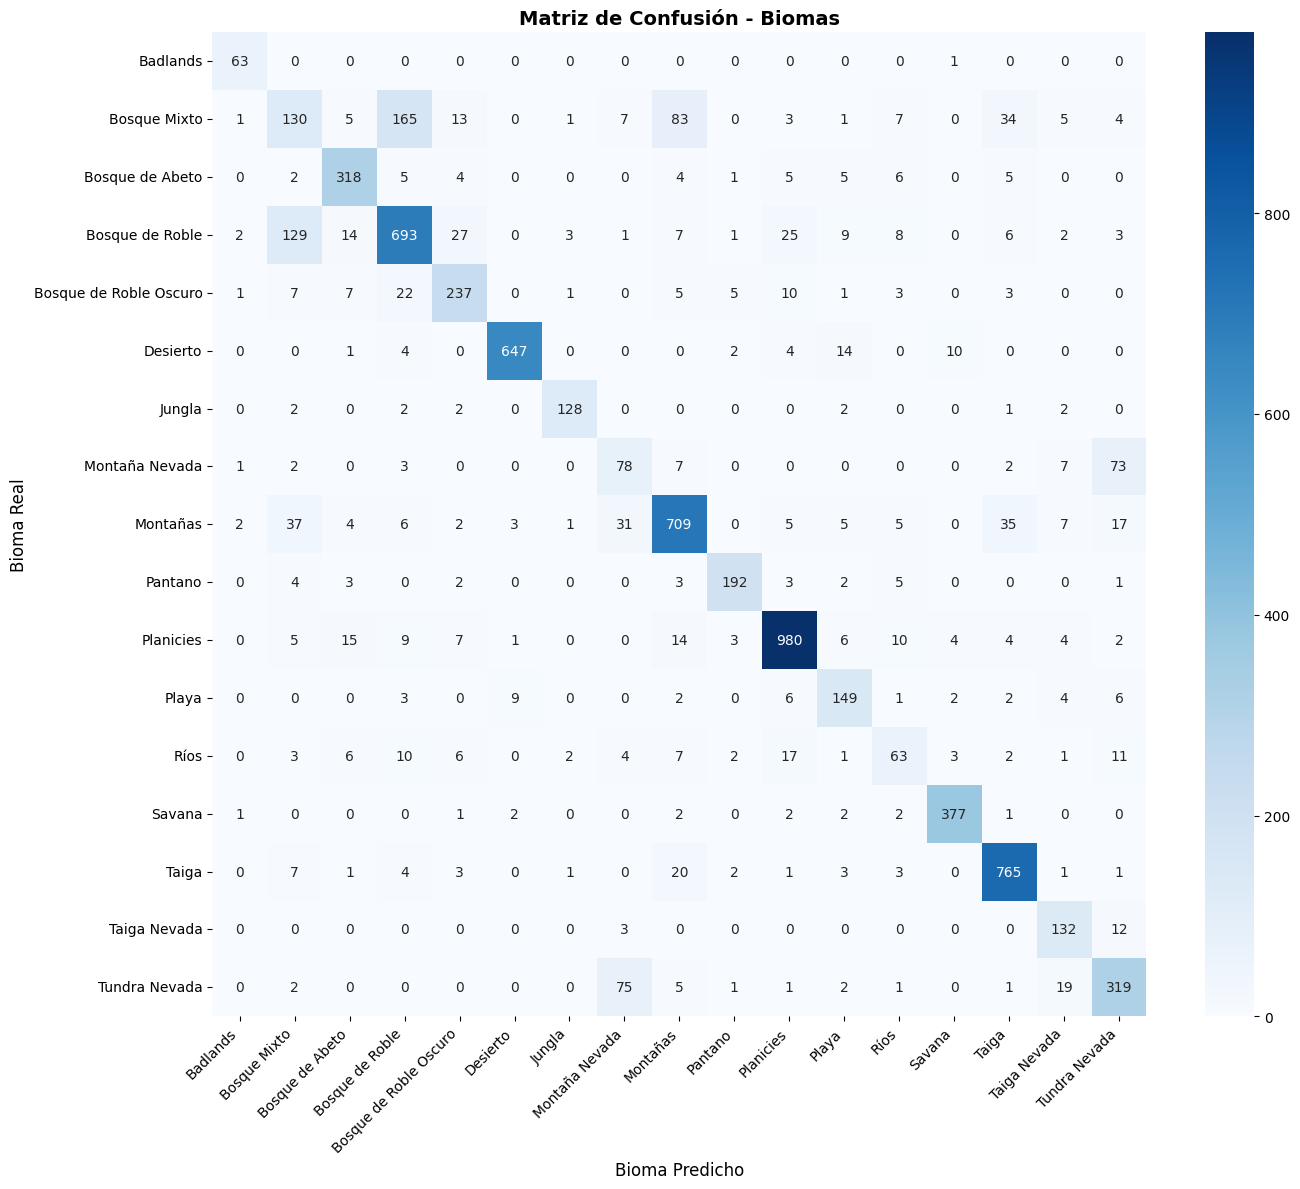

Gráfico de Matriz de Confusión generado.

--- FASE 6: Guardando modelo ---
Modelo guardado en /kaggle/working/auto_model_estandar_20251104_200123.pth

--- FLUJO AUTOMÁTICO COMPLETADO ---


In [9]:
if __name__ == "__main__":
    np.random.seed(SEMILLA_ALEATORIA)
    torch.manual_seed(SEMILLA_ALEATORIA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEMILLA_ALEATORIA)

    tipo_ejecucion_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')

    if tipo_ejecucion_kaggle == 'Interactive':
        print("--- MODO INTERACTIVO (DRAFT) ---")
        print("Iniciando menú principal. Podrá usar 'input()'.\n")
        menu_principal()
    
    else:
        if tipo_ejecucion_kaggle == 'Batch':
            print("--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---")
        else:
            print(f"--- MODO NO INTERACTIVO (Fallback, KAGGLE_KERNEL_RUN_TYPE={tipo_ejecucion_kaggle}) ---")
        
        print("Iniciando flujo automático (sin inputs).\n")
        
        modelo_automatico = None
        params_arquitectura_auto = None
        historial_perdida_auto = []
        dispositivo_auto = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f" (Usando dispositivo: {dispositivo_auto})")

        try:
            print("\n--- FASE 1: Agrupando y verificando el dataset ---")
            if not preparar_y_agrupar_biomas():
                print("Error crítico en la agrupación del dataset. Abortando.")
                sys.exit(1)

            print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
            datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
            if datos_entrenamiento is None:
                print("No se pudieron cargar los datos. Abortando.")
                sys.exit(1)

            print("\n--- FASE 3: Creación de Modelo (CNN) ---")
            tipo_arquitectura_auto = "estandar"
            print(f"Arquitectura seleccionada: {tipo_arquitectura_auto}")
            
            params_arquitectura_auto = {
                'num_classes': numero_de_clases,
                'architecture_type': tipo_arquitectura_auto
            }
            params_creacion_auto = {
                'numero_de_clases': params_arquitectura_auto['num_classes'],
                'tipo_arquitectura': params_arquitectura_auto['architecture_type']
            }
            
            modelo_automatico = ClasificadorBiomasCNN(**params_creacion_auto).to(dispositivo_auto)
            print("\n--- Nueva Red CNN Creada ---")

            epocas_auto = 100
            lr_auto = 0.001
            porcentaje_auto = 1.0
            print(f"\n--- FASE 4: Iniciando Entrenamiento ---")
            print(f"Épocas: {epocas_auto}, LR: {lr_auto}, Dataset: {porcentaje_auto*100:.0f}%")
            
            total_muestras = len(pesos_muestras_tensor)
            muestras_a_usar = int(total_muestras * porcentaje_auto)
            muestreador_auto = torch.utils.data.WeightedRandomSampler(
                weights=pesos_muestras_tensor,
                num_samples=muestras_a_usar,
                replacement=True
            )
            cargador_entrenamiento_auto = DataLoader(datos_entrenamiento,
                                                    batch_size=TAMANO_LOTE,
                                                    sampler=muestreador_auto,
                                                    num_workers=2,
                                                    pin_memory=True)
            
            nueva_perdida_auto = entrenar_modelo(modelo_automatico, cargador_entrenamiento_auto, epocas_auto, lr_auto, dispositivo_auto)
            historial_perdida_auto.extend(nueva_perdida_auto)
            
            print("Generando gráfico de pérdida...")
            graficar_historial_perdida(historial_perdida_auto)

            print(f"\n--- FASE 5: Probando modelo en {dispositivo_auto} ---")
            evaluar_modelo(modelo_automatico, cargador_validacion, dispositivo_auto, nombres_clases)

            print("\n--- FASE 6: Guardando modelo ---")
            marca_temporal = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo_modelo = f"auto_model_estandar_{marca_temporal}.pth"
            guardar_red_neuronal(modelo_automatico, params_arquitectura_auto, nombre_archivo_modelo)
            
            print("\n--- FLUJO AUTOMÁTICO COMPLETADO ---")

        except Exception as e:
            print(f"Ocurrió un error en el flujo automático: {e}")
            import traceback
            traceback.print_exc()
            sys.exit(1)